# Proximity analysis
In this notebook we will be working with data from [OpenStreetMap](https://openstreetmap.org) to do proximity analysis to various urban amenities.

In [128]:
import geopandas
from matplotlib.colors import ListedColormap
import osmnx as ox
import pyproj
from shapely.ops import transform

%matplotlib inline

ox.config(log_console=True, use_cache=True)
ox.__version__

'0.15.1'

## Import data
We import pre-processed data from OpenStreetMap. Rather than working on a whole country or city, we have selected a subset of the city of Tampere. We have also divided the data into three categories: food sources, bus stops, and building footprints.

In [129]:
location = {
    "city": "Tampere",
    "state": "Pirkanmaa",
    "country": "Finland",
}

location_df = ox.geocode_to_gdf(location)

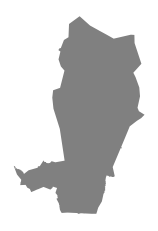

In [130]:
location_proj = ox.project_gdf(location_df)
ax = location_proj.plot(fc='gray', ec='none')
_ = ax.axis('off')

### Food sources

In [131]:
%%time
food_sources_tags = {
    "shop": [
        "supermarket",
        "convenience",
        "bakery",
    ]
}
food_sources_gdf = ox.pois_from_place(location, food_sources_tags)
food_sources_gdf.shape

CPU times: user 426 ms, sys: 7.99 ms, total: 434 ms
Wall time: 462 ms


(137, 54)

In [132]:
food_sources_gdf.head()

,osmid,geometry,amenity,element_type,shop,name,opening_hours,addr:city,addr:housenumber,addr:postcode,...,name:fi,name:sv,building:levels,roof:levels,takeaway:covid19,area,addr:housename,source:outline,mml:ref,description:covid19
33057409,33057409,POINT (23.60502 61.50775),retail,node,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33072615,33072615,POINT (23.62823 61.50601),NaN,node,bakery,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33403024,33403024,POINT (23.66238 61.50771),NaN,node,bakery,Jussinhannan Leipä Oy Kahvila-Myymälä,Mo-Fr 6:30-17:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33403046,33403046,POINT (23.68640 61.50778),NaN,node,convenience,K-Market Haapalinna,Mo-Su 7:00-23:00,Tampere,191,33270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59359661,59359661,POINT (23.78001 61.47957),NaN,node,supermarket,Nekalan Suurjako,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

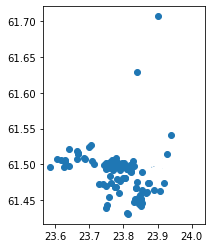

In [133]:
food_sources_gdf.plot()

### Bus stops

In [134]:
%%time
bus_stops_tags = {
    "amenity" : True,
    "highway" : "bus_stop"
}
bus_stops_gdf = ox.pois_from_place(location, bus_stops_tags)
bus_stops_gdf.shape

CPU times: user 10.5 s, sys: 108 ms, total: 10.6 s
Wall time: 10.6 s


(5026, 359)

<AxesSubplot:>

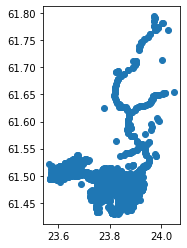

In [135]:
bus_stops_gdf.plot()

### Buildings

In [136]:
%%time
buildings_gdf = ox.footprints.footprints_from_place(location)
buildings_gdf.shape

CPU times: user 9.3 s, sys: 276 ms, total: 9.57 s
Wall time: 31.3 s


(40121, 212)

<AxesSubplot:>

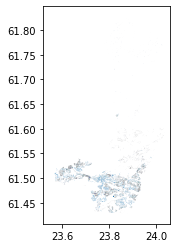

In [137]:
buildings_gdf.plot()

## Project the data

In [138]:
%%time
food_sources_gdf.to_crs(epsg=3857, inplace=True)

CPU times: user 67.4 ms, sys: 0 ns, total: 67.4 ms
Wall time: 67.9 ms


In [139]:
%%time
bus_stops_gdf.to_crs(epsg=3857, inplace=True)

CPU times: user 339 ms, sys: 17 µs, total: 339 ms
Wall time: 342 ms


In [140]:
%%time
buildings_gdf.to_crs(epsg=3857, inplace=True)

CPU times: user 3.6 s, sys: 3.85 ms, total: 3.6 s
Wall time: 3.63 s


## Building centroids
Building geometries have varying numbers of points and lines, or complexity. We can simplify things by reducing each building footprint to the aproximate center, or centroid.

In [141]:
%%time
buildings_gdf["centroid"] = buildings_gdf["geometry"].centroid

CPU times: user 397 ms, sys: 7.98 ms, total: 405 ms
Wall time: 410 ms


In [142]:
buildings_gdf.head()

,nodes,building,name,geometry,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,cuisine,...,seamark:landmark:category,seamark:type,proposed,bicycle_parking,bell_tower,postal_code,members,type,historic:name,centroid
4881423,"[31577656, 3962324130, 3962324129, 3962324128,...",retail,Tesoman liikekeskus,"POLYGON ((2630290.258 8742900.292, 2630278.357...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2630225.788 8742972.055)
4881487,"[31579064, 31579065, 33057050, 33057069, 31579...",yes,Nokian Autogrilli Tesoma,"POLYGON ((2629091.135 8742698.292, 2629095.644...",Tampere,14,33310,Tesomankatu,fast_food,kebab,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2629108.895 8742694.220)
4881551,"[31582436, 31582437, 31582438, 1139766076, 315...",retail,K-Market Winterinmutka,"POLYGON ((2634712.146 8743523.360, 2634786.396...",NaN,126,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2634757.358 8743507.709)
4900964,"[31927381, 1140935344, 1140935209, 31927396, 3...",school,Tesomajärven koulu,"POLYGON ((2629387.902 8743178.345, 2629367.430...",Tampere,7,33310,Raiskionkatu,school,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2629435.841 8743196.911)
4983894,"[33051014, 33051011, 33051012, 33051013, 33051...",yes,NaN,"POLYGON ((2637171.795 8743326.127, 2637205.491...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2637191.237 8743327.620)


Since subsequent steps will work with a column called "geometry", we will swap our complicated footprints with the simple centroids by renaming columns.

In [143]:
buildings_gdf.rename(
    columns={
        "geometry": "footprint",
        "centroid": "geometry"
    }, 
    inplace=True
)

In [144]:
buildings_gdf.head()

,nodes,building,name,footprint,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,cuisine,...,seamark:landmark:category,seamark:type,proposed,bicycle_parking,bell_tower,postal_code,members,type,historic:name,geometry
4881423,"[31577656, 3962324130, 3962324129, 3962324128,...",retail,Tesoman liikekeskus,"POLYGON ((2630290.258 8742900.292, 2630278.357...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2630225.788 8742972.055)
4881487,"[31579064, 31579065, 33057050, 33057069, 31579...",yes,Nokian Autogrilli Tesoma,"POLYGON ((2629091.135 8742698.292, 2629095.644...",Tampere,14,33310,Tesomankatu,fast_food,kebab,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2629108.895 8742694.220)
4881551,"[31582436, 31582437, 31582438, 1139766076, 315...",retail,K-Market Winterinmutka,"POLYGON ((2634712.146 8743523.360, 2634786.396...",NaN,126,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2634757.358 8743507.709)
4900964,"[31927381, 1140935344, 1140935209, 31927396, 3...",school,Tesomajärven koulu,"POLYGON ((2629387.902 8743178.345, 2629367.430...",Tampere,7,33310,Raiskionkatu,school,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2629435.841 8743196.911)
4983894,"[33051014, 33051011, 33051012, 33051013, 33051...",yes,NaN,"POLYGON ((2637171.795 8743326.127, 2637205.491...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2637191.237 8743327.620)


Let's just double check that we still have two geometry columns.

In [145]:
buildings_gdf.dtypes

nodes              object
building           object
name               object
footprint        geometry
addr:city          object
                   ...   
postal_code        object
members            object
type               object
historic:name      object
geometry         geometry
Length: 213, dtype: object

## Create buffers
Next we will create "convenience" distances around each point in our data sets. Convenience is a hypothetical measure of how far people could reasonably access the amenities. These values are purely hypothetical, in order that we can work out further analysis below.

### Food sources

CPU times: user 149 ms, sys: 24 ms, total: 173 ms
Wall time: 126 ms


<AxesSubplot:>

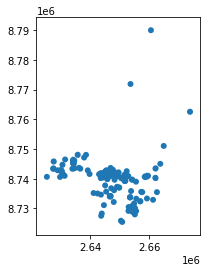

In [146]:
%%time
buffer_distance_m = 1000

food_sources_buffered = food_sources_gdf.buffer(buffer_distance_m)

food_sources_buffered.plot()

### Bus stops

CPU times: user 2.96 s, sys: 32.1 ms, total: 2.99 s
Wall time: 2.93 s


<AxesSubplot:>

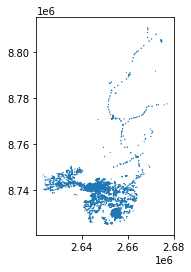

In [147]:
%%time
buffer_distance_m = 250

bus_stops_buffered = bus_stops_gdf.buffer(buffer_distance_m)

bus_stops_buffered.plot()

## Amenity catchments
Since the buffering step makes many separate and overlapping circles, we will combine the overlapping circles into larger "catchments".

### Food sources

In [148]:
%%time
food_sources_catchment = food_sources_buffered.unary_union

CPU times: user 200 ms, sys: 0 ns, total: 200 ms
Wall time: 200 ms


### Bus stops

In [149]:
bus_stops_catchment = bus_stops_buffered.unary_union

## Access to amenities
Now we will combine the food and bus catchments for a composite measure of "access to amenities". We can combine arbitrarily many amenities here, but will start with the two previously mentioned.

In [150]:
%%time
access_to_amenities = bus_stops_catchment.intersection(food_sources_catchment)

CPU times: user 221 ms, sys: 0 ns, total: 221 ms
Wall time: 222 ms


## Buildings within food catchment
Now we can search for buildings that are within the various catchments previously calculated.

In [151]:
%%time
buildings_gdf["within_food_catchment"] = buildings_gdf.within(food_sources_catchment)

CPU times: user 1min 9s, sys: 11.8 ms, total: 1min 9s
Wall time: 1min 9s


In [154]:
buildings_gdf["within_food_catchment"].value_counts(normalize=True)

False    0.568755
True     0.431245
Name: within_food_catchment, dtype: float64

In [155]:
%%time
# Warning, the following is slow, only run if needed
#buildings["within_bus_catchment"] = buildings.within(bus_stops_catchment)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


The next step will likely take several minutes. You may want to get a cup of tea.

In [156]:
%%time
buildings_gdf["access_to_amenities"] = buildings_gdf.within(access_to_amenities)

CPU times: user 8min 16s, sys: 124 ms, total: 8min 16s
Wall time: 8min 17s


In [158]:
buildings_gdf["access_to_amenities"].value_counts(normalize=True)

False    0.70402
True     0.29598
Name: access_to_amenities, dtype: float64

### Visual representation
Let's take a look at the catchments to spot any differences.

In [159]:
colormap = ListedColormap(["coral", "forestgreen"])

<AxesSubplot:>

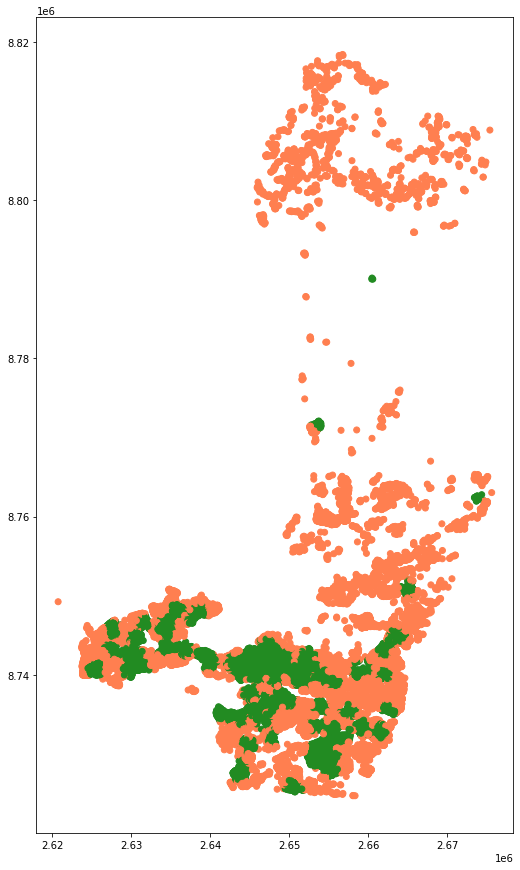

In [160]:
buildings_gdf.plot(categorical=True, column="within_food_catchment",figsize=(20, 15), cmap=colormap)

<AxesSubplot:>

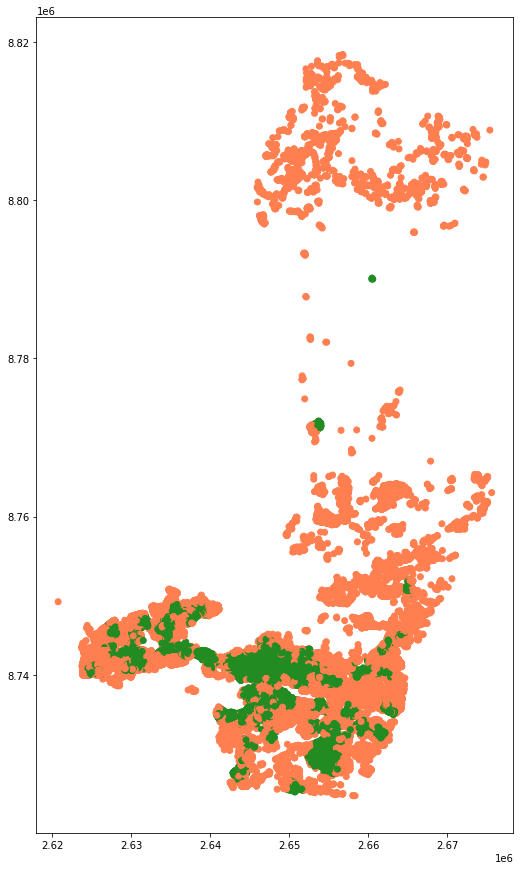

In [161]:
buildings_gdf.plot(categorical=True, column="access_to_amenities",figsize=(20, 15), cmap=colormap)

### Proportional representation
We can also calculate the proportion of buildings that meet the convenience criteria. This can be useful for tracking the change over time.

In [162]:
buildings_gdf["access_to_amenities"].value_counts(normalize=True)

False    0.70402
True     0.29598
Name: access_to_amenities, dtype: float64